# Improving my previous work (Notebook 2)

So, two major disadvantages of the dataset used in the previous notebook were:

- Not enough representation when it comes to NSFW artworks
- The SFW dataset was quite weak, did not have any SFW selfies (which resulted in any selfie being classified as NSFW) and Lorem Picsum only has abstract placeholder images, which are only a fraction of the representation for images that may be uploaded for testing.

Additionally, after reading my previous report, my mentor Abbasi Daniyal recommended the following changes:

- Adding the Reduce LR and Early Stopping callbacks
- Reducing the learning rate (or) increasing the number of trainable neurons because the training and validation losses are not going down smoothly.

I address these disadvantages and recommendations in this notebook :D

# 1. Increasing my dataset

- I add the dataset provided by Kaggle user Vareza Noorliko which deals with NSFW artwork. Luckily, this dataset is classified into 2 classes, NSFW artwork and SFW artwork. Link: https://www.kaggle.com/drakedtrex/my-nsfw-dataset?


- I thought of using the NudeNet Classifier Dataset but it contains about 19 GB of data. My RAM cannot handle that data plus I already have a lot of images in that subcategory, so I skip it for now. Link: https://archive.org/details/NudeNet_classifier_dataset_v1


- After this, I used the imgur API via postman (free for non-commercial use). Took me a while to figure out, but this helped with generating more NSFW images (via the {{show mature}} header). Link: https://apidocs.imgur.com/


- Next, searching on Google for SFW datasets brought me to this subreddit post: https://www.reddit.com/r/datasets/comments/ip5yex/selfpromotion_need_sfw_selfies_dataset/ Summary: This user has the same problem as me! The answers to this post directed me to 3 helpful websites: www.shutterstock.com, www.pexels.com, and www.flickr.com. I found this extremely helpful website that downloads all images in a website and packages it in a .zip file (I know I could have written a script, but then I found this): https://imagecyborg.com/


- For NSFW images, for the time being, I downloaded relevant images related to porn. For SFW, however, I downloaded images categorized as follows: full body, selfies, mirror selfies, middle aged women, party, college party, nightclub, animals, places, food and objects.

# 2. Fixing the image processing errors in my dataset

- I probably had around 5000 images in each class at the end. I ran them through an image duplication detection script. After this, I ran the following script to make sure that all the final images are actually readable (this is because I received an error saying: *cannot identify image file <_io.BytesIO object*)


<code>    os.chdir(path_to_the_file_you_want_to_investigate)
        for im in os.listdir():
            im2 = Image.open(im)
</code>

- This made me realize that if I want to increase the data in my datasets next time, I should not visit ShutterStock because almost all of their thumbnails are bytes files which are unreadable by PIL and hence cannot be trained on. Next, I got a DecompressionBombWarning for exceeding the limit for maximum pixels for a singular image. Of course, I could have disabled that feature of PIL but I don't really trust the websites 100% so I removed that one picture that caused that warning. 

- Finally, the following is an overview of my dataset:

**NSFW Train**: 3231 images  
**NSFW Validation**: 1076 images  
**NSFW Test**: 1066 images

**SFW Train**: 3140 images  
**SFW Validation**:1048 images  
**SFW Test**: 1060 images  

In [30]:
import os
import io
import cv2
import keras
import random
from IPython.display import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing import image

In [4]:
#os.chdir(r'D:\Data\Train\SFW')
#for im in os.listdir():
#    im2 = Image.open(im)

In [5]:
nsfw_images = [fn for fn in os.listdir(r'D:\Data\Train\NSFW') if fn.endswith('.jpg')]
sfw_images = [fn for fn in os.listdir(r'D:\Data\Train\SFW') if fn.endswith('.jpg')]
train_dir = r'D:\Data\Train'
validation_dir = r'D:\Data\Validation'

In [6]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top=False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable=False

In [5]:
"""class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.959):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True"""

'class myCallback(tf.keras.callbacks.Callback):\n    def on_epoch_end(self, epoch, logs={}):\n        if(logs.get(\'acc\')>0.959):\n            print("\nReached 99.9% accuracy so cancelling training!")\n            self.model.stop_training = True'

# 3. Adding the required callbacks

I added the callbacks of "early stopping", "reduce LR", and model checkpoint (although I disabled the save_best_only for now).
I also reduce the initial learning rate from 0.0001 to 0.00001.

In [7]:
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
callback_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.6f}.h5', save_weights_only=True, 
                                                               monitor='val_acc', mode='max', save_best_only=False)

In [8]:
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers. Dense(2, activation='softmax')(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer = Adam(lr=0.00001),
             loss='categorical_crossentropy',
             metrics= keras.metrics.BinaryAccuracy())

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 30,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 30,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 6363 images belonging to 2 classes.
Found 2124 images belonging to 2 classes.


In [41]:
"""os.chdir(r'D:\Data\Validation\SFW')
i = 0
for file in os.listdir():
    os.rename(file, "sfw_validate_" + str(i) +".jpg")
    i = i+1"""

'os.chdir(r\'D:\\Data\\Validation\\SFW\')\ni = 0\nfor file in os.listdir():\n    os.rename(file, "sfw_validate_" + str(i) +".jpg")\n    i = i+1'

In [ ]:
"""os.chdir(r'D:\Data\Train\NSFW')
byteImgIO = io.BytesIO()
for i in os.listdir():
    try:
        byteImg = Image.open(i)
        byteImg.save(byteImgIO, "PNG")
        byteImgIO.seek(0)
        byteImg = byteImgIO.read()
    except:
        continue"""

# 4. Training and performance

Now comes the training. I only trained it for 20 epochs because this took me a while, but I am guessing that training for 30-40 epochs would be ideal. I was able to achieve an **accuracy of 94.44% on the Validation set** despite the huge increase in data! I have also attached the train and validation accuracy and loss progressions with each epoch. 

In [13]:
batch_size = 30
#callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = int(6363/batch_size),
            epochs = 20,
            validation_steps=int(2124/batch_size),
            verbose=2, callbacks=[callback_early_stopping, callback_reduce_lr, callback_model_checkpoint])

Epoch 1/20
212/212 - 449s - loss: 0.3517 - binary_accuracy: 0.8783 - val_loss: 0.2653 - val_binary_accuracy: 0.9159
Epoch 2/20
212/212 - 414s - loss: 0.3063 - binary_accuracy: 0.8907 - val_loss: 0.2245 - val_binary_accuracy: 0.9175
Epoch 3/20
212/212 - 408s - loss: 0.2751 - binary_accuracy: 0.8942 - val_loss: 0.2000 - val_binary_accuracy: 0.9286
Epoch 4/20
212/212 - 404s - loss: 0.2561 - binary_accuracy: 0.9030 - val_loss: 0.2161 - val_binary_accuracy: 0.9198
Epoch 5/20
212/212 - 411s - loss: 0.2417 - binary_accuracy: 0.9046 - val_loss: 0.1925 - val_binary_accuracy: 0.9222
Epoch 6/20
212/212 - 478s - loss: 0.2314 - binary_accuracy: 0.9103 - val_loss: 0.1766 - val_binary_accuracy: 0.9302
Epoch 7/20
212/212 - 453s - loss: 0.2229 - binary_accuracy: 0.9089 - val_loss: 0.1901 - val_binary_accuracy: 0.9270
Epoch 8/20
212/212 - 407s - loss: 0.2284 - binary_accuracy: 0.9103 - val_loss: 0.1929 - val_binary_accuracy: 0.9238
Epoch 9/20
212/212 - 407s - loss: 0.2219 - binary_accuracy: 0.9114 - val

In [1]:
#model.weights

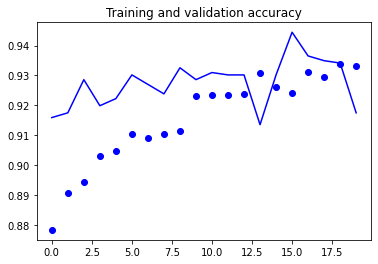

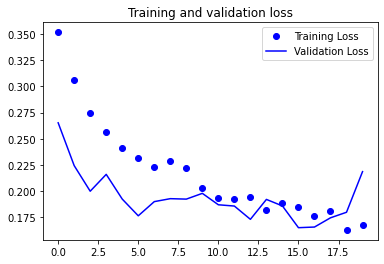

In [16]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
model.save('model_inceptionV3.h5')

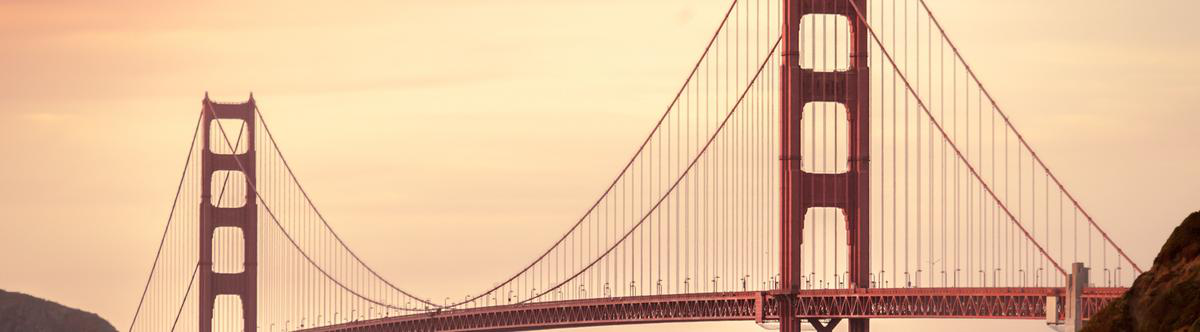

This is a SFW image


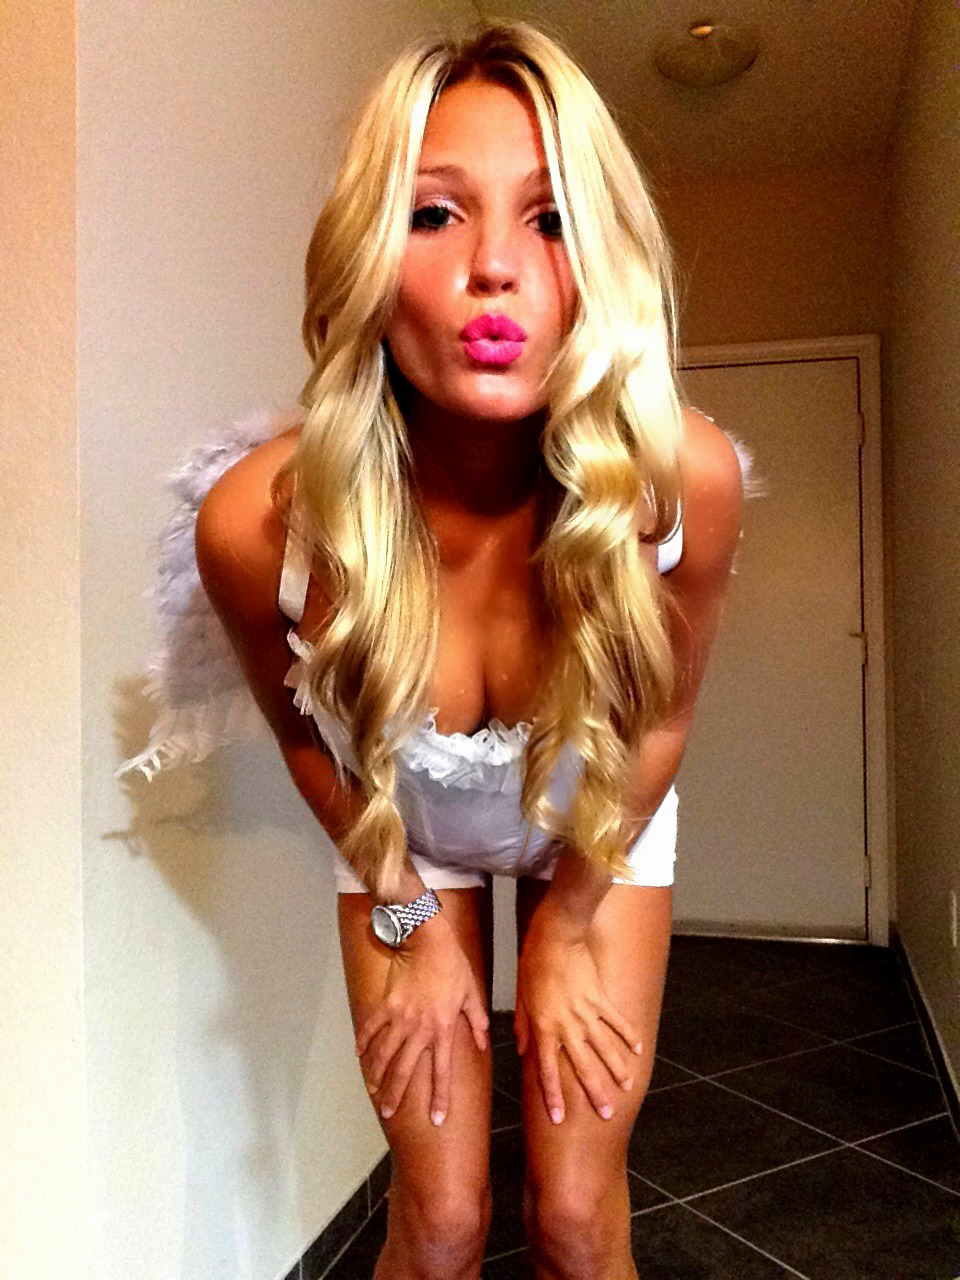

This is an NSFW image


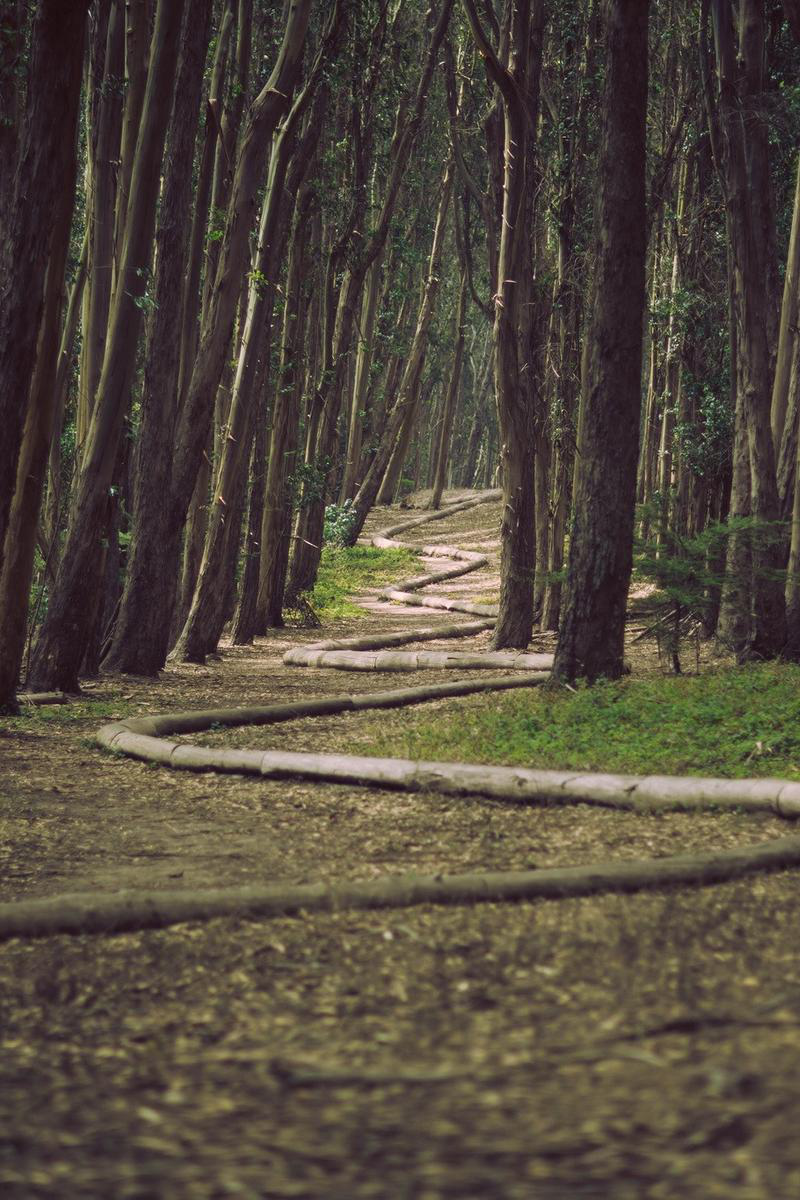

This is a SFW image


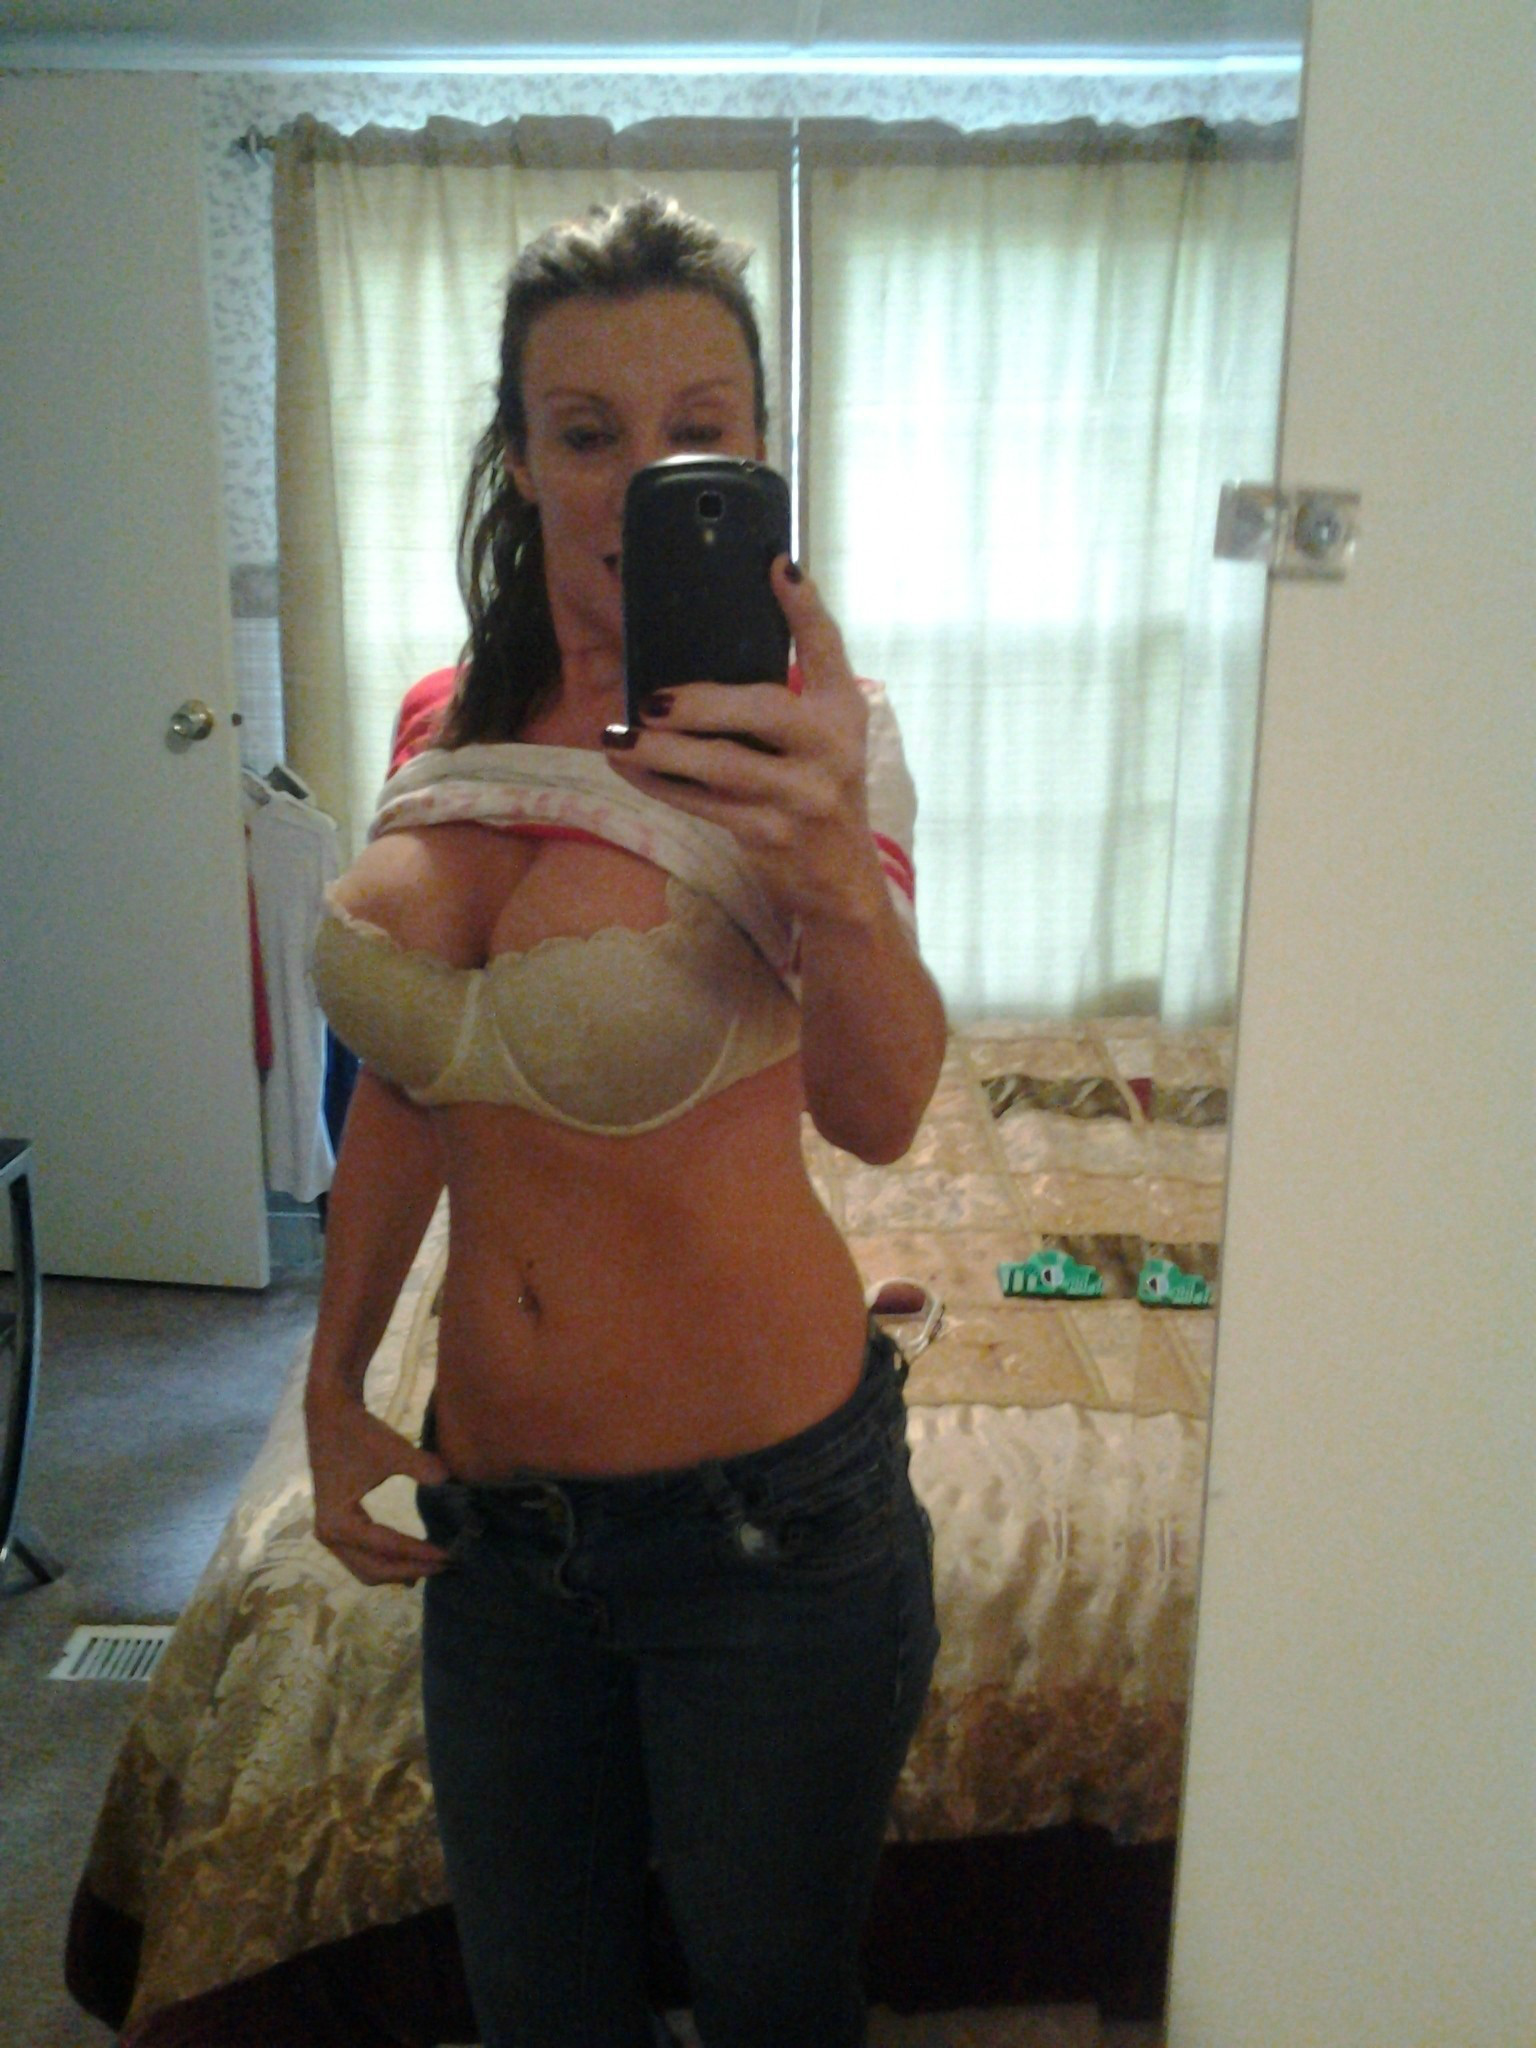

This is an NSFW image


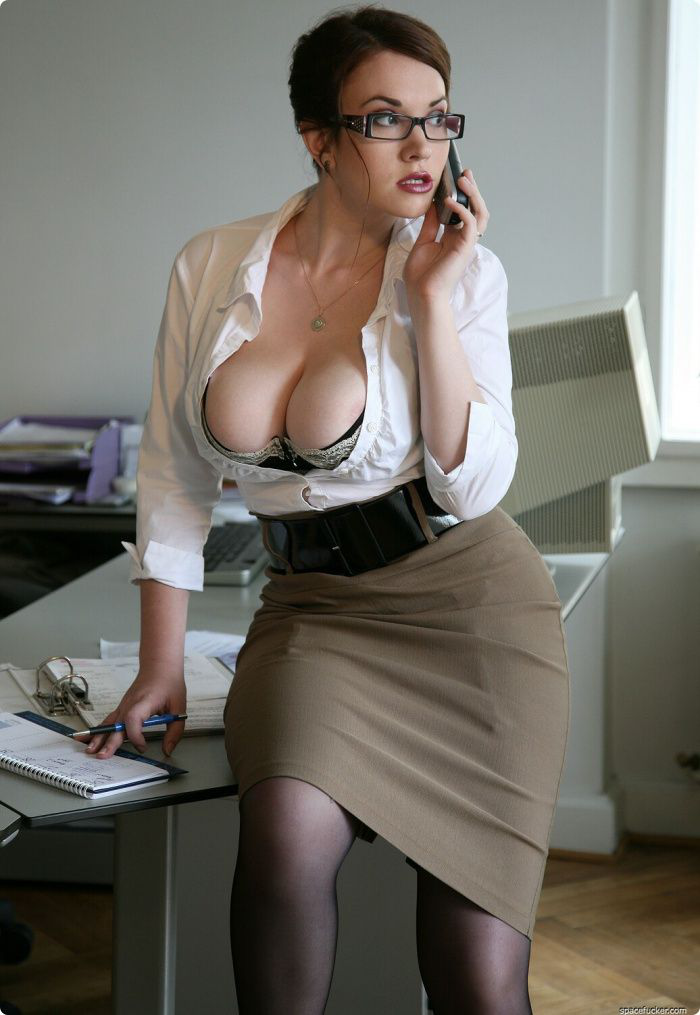

This is an NSFW image


In [46]:
os.chdir(r'D:\Data\Test')

number_of_random_images = 0
img_list = []

while (number_of_random_images<5):
    img_list.append(random.choice(os.listdir(os.getcwd())))
    number_of_random_images = number_of_random_images + 1
    
#img_list2 = ['img 70.jpg', 'img 74.jpg', 'img 100.jpg', 'img 105.jpg']

for test_img in img_list:
    #display(Image(filename=test_img, height=100, width=100))
    display(Image.open(test_img))
    img = image.load_img(test_img, target_size=(150, 150))
    img = image.img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    yhat = model.predict(img)
    if(np.argmax(yhat) == 0):
        print("This is an NSFW image")
    else:
        print("This is a SFW image")   

# 5. Next steps

Now that I have a moderately good dataset that encompasses different types of NSFW as well as SFW media, I can use this for comparable performance. Next, I will be implementing the MobileNet architecture, which was my originally proposed model due to a less amount of hyper-parameters to regulate as well as due to the light-weight nature of the model (it's only a couple of MB huge).

As of now, I am still finding solutions on the following drawbacks:
- Not enough training data for POC: majority of the NSFW images that were scrapped are of caucasian people
- Building a model to detect NSFW content in videos